In [24]:
os.getcwd()
#os.chdir('data_sets')
os.getcwd()

'C:\\Users\\hesam\\Stock_analysis_python\\data_sets'

In [25]:
"""
UNIX timestamp convertor functions:
    date_convertor function takes the human readable date in MM/DD/YYYY format and returns Unix
    Timestamp in integer format
    timestamp_converot function takes the UNIX timestamp format and returns human readable date in
    MM/DD/YYYY format
"""

def date_convertor(date):
    #convert the time to UNIX timestamp
    import time
    result = int(time.mktime(time.strptime(date, "%d/%m/%Y")))
    return result #Returns Integer type
    


def timestamp_convertor(timestamp):
        import datetime
        result = datetime.datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d')
        return result #Returns String type


'''Company Symbols'''
# table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# df = table[0]
# df.to_csv('S&P500-Info.csv')
# df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

def get_companies_info():
    with open ("S&P500-Info.csv","r") as f:
        companies = f.readlines()
    
    
    company_list = []
    company_dictionary = {}
    
    for line in companies:
        line_list = line.strip('\n').split(",")
        company_list.append(line_list)
        # company_dictionary[line[1]]=line[2:]
    # symbols = companies[:]
    #print (company_list)
    dictionary_guide ={}
    dictionary_guide[company_list[0][1]]=company_list[0][2:]
    
    
    print("Dictionary Guide: ",dictionary_guide)
    
    for company in company_list[0:101]:
        company_dictionary[company[1]]=company[2:]
        
    return company_dictionary

'''
Function for updating all the files in the database
'''
def update_dataset():
    import os
    import finnhub
    import pandas as pd
    # start_date = input("Enter the start date in mm/dd/yyyy format: ")
    # end_date = input("Enter the end date in mm/dd/yyyy format: ")
       
    companies = get_companies_info()
    
    start_date = "01/01/2019"
    end_date = "01/02/2019"
    start_date, end_date = date_convertor(start_date), date_convertor(end_date)
    print(start_date, end_date)
    
    os.chdir("data_sets")
    
    # Setup client
    finnhub_client = finnhub.Client(api_key ="bui229f48v6rfhsb6s50")
    
    for company in companies:
        try:
            print(company)   
            # Stock candles
            res = finnhub_client.stock_candles(company, 'D', start_date, end_date)
            #print(res)
            
            #Convert to Pandas Dataframe 
            response = pd.DataFrame(res)  
            
            #Write the CSV file out of data frame
            response_csv = response.to_csv(f"{company}.csv")
        except:
            print('no company found ...')
 
'''
Function for returning information about specific company
'''
def get_company_data(company):
    import os

    with open (f"{company}.csv", "r") as c:
        company_data = c.readlines()
    #pd.DataFrame(company_data)
    return company_data[1:]

'''
Function for getting a dictionary for all the changes in prices in the gathered files
and calculating price changes 
'''    
def refine_companies_records():
    import os
    from classes import DeltaObject
    
    companies = get_companies_info()
    #os.chdir('data_sets')
    files = os.listdir()
    companies_records = {}
    for company in companies:
        #print (True)
        if (company + '.csv') in files:
            # print('in files: ', True)
            company_data = get_company_data(company)
            
            #get close prices in a list
            close_price_list = []
            for line in company_data:
                date_price = []
                line = line.strip('\n').split(',')
                #close_price_list.append(line[1])
                date_price.append(line[1])
                date_price.append(line[6])
                close_price_list.append(date_price)
            
            #calculate the change in prices each day
            change_list = []
            
            for i in range(1,len(close_price_list)):
    
                delta_change = float(close_price_list[i][0]) - float(close_price_list[i-1][0])
                percent_change = delta_change / float(close_price_list[i-1][0])
                dates =(close_price_list[i-1][1],close_price_list[i][1])
                
                
                change_list.append(DeltaObject(delta_change,percent_change,dates))
            
            companies_records[company]= change_list
                     
    return companies_records



def export_to_json():
    import json
    records = refine_companies_records()
        
    json_data = json.dumps(records, default=lambda o: o.__dict__, indent=4)
      
    with open ('companies_records.json', 'w') as f:
                 f.write(json_data)
    

In [26]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

companies = get_companies_info()


companies_records = refine_companies_records()
#companies = [key for key in companies_records]

user_input= input("Enter the symbol of the company or type HELP: ").upper()
  
    
if user_input == "HELP":
    #print(companies)
    data = pd.DataFrame.from_dict(companies, orient = 'index')
    pd.set_option('display.max_rows', None)
    #pd.set_option('display.max_columns', 5)
    print("list of companies: \n", data)
    
else:
    if user_input in companies:
        company_data = companies_records[user_input.upper()]
        #print(companies_records[user_input.upper()])
        print(company_data)
        print("Working on it ...")
        
        #data_frame= pd.DataFrame()
        rows = [company_data[i].dates for i in range(len(company_data))]
        columns = [c for c in companies ][1:]
        
        # for company in companies_records:

 
def get_compared_datapoints(company_data):
        #let's compare data for the company with it's corrosponding data point in other companies
        data_points = []
        dict_of_dates = {}
        
        for i in company_data:
            date = i.dates
            change = i.change
            percent = i.percent
            
            lc=[]
            
            for symbol in companies_records:
                company_to_compare = companies_records[symbol]
                
                for k in company_to_compare:
                    date_k = k.dates
                    change_k = k.change
                    percent_k = k.percent
                    
                    #set color of the comparison result
                    if date == date_k:
                        if (change*change_k)<=0:
                            same_change = [1,0,0]#False #show in Red color
                        else:
                            same_change = [0,1,0]#True #show in Green color
                    
                        # Set Color Opacity
                        try:
                            relational_opacity = round(abs(percent_k/percent),2)
                            if relational_opacity >=1:
                                relational_opacity = 1
                            
                        except:
                        
                            relational_opacity = 0
                       
                        #data_point = (same_change, relational_opacity)
                        same_change.append(relational_opacity)
                        data_point = tuple(same_change)
                        #print(data_point)                        
                        data_points.append(data_point)
                    
                        company_date_dict = {symbol:data_point}

                        lc.append(company_date_dict)

            dict_of_dates[date] = lc
            
        results = dict_of_dates
        
        #merge separate dictionaries that are created in the last step
        for date in results:
            merged_dict={}
            for d in results[date]:
                merged_dict.update(d) 
            results[date] = merged_dict
        
        return results
    
result = get_compared_datapoints(company_data)

dataframe = pd.DataFrame(result)
#dataframe=pd.DataFrame.from_dict(result)
#_dataframe = pd.DataFrame.transpose(dataframe)


#dataframe.plot.scatter(x="dates",y="company", c='DarkBlue')
           
# for i, j in dataframe.iterrows():
#     print(i)
#     print(list(j.values))
#     print()             

Dictionary Guide:  {'Symbol': ['Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded']}
Dictionary Guide:  {'Symbol': ['Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded']}
Enter the symbol of the company or type HELP: a
[-0.7600021362299998,-0.01873772461779219,('1420156800', '1420416000'), -0.6199989318850001,-0.015577862908792945,('1420416000', '1420502400'), 0.5200004577629969,0.013272089170818626,('1420502400', '1420588800'), 1.1899986267089986,0.02997477591536708,('1420588800', '1420675200'), -0.29999923705999976,-0.0073367386044997035,('1420675200', '1420761600'), -0.47999954223599417,-0.011825561478974018,('1420761600', '1421020800'), -0.5600013732910014,-0.013961639610308819,('1421020800', '1421107200'), -0.4899978637700002,-0.01238932675656892,('1421107200', '1421193600'), -1.0500030517580043,-0.026881797614989083,('1421193600', '14212

## Getting details of the dataframe

In [27]:
dataframe.dtypes

1420156800  1420416000    object
1420416000  1420502400    object
1420502400  1420588800    object
1420588800  1420675200    object
1420675200  1420761600    object
                           ...  
1577059200  1577145600    object
1577145600  1577318400    object
1577318400  1577404800    object
1577404800  1577664000    object
1577664000  1577750400    object
Length: 1257, dtype: object

In [32]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, MMM to AVB
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   (1546387200, 1546473600)  58 non-null     object
 1   (1546473600, 1546560000)  58 non-null     object
 2   (1546560000, 1546819200)  58 non-null     object
 3   (1546819200, 1546905600)  58 non-null     object
 4   (1546905600, 1546992000)  58 non-null     object
 5   (1546992000, 1547078400)  58 non-null     object
 6   (1547078400, 1547164800)  58 non-null     object
 7   (1547164800, 1547424000)  58 non-null     object
 8   (1547424000, 1547510400)  58 non-null     object
 9   (1547510400, 1547596800)  58 non-null     object
 10  (1547596800, 1547683200)  58 non-null     object
 11  (1547683200, 1547769600)  58 non-null     object
 12  (1547769600, 1548115200)  58 non-null     object
 13  (1548115200, 1548201600)  58 non-null     object
 14  (1548201600, 1548288000)  58 n

In [9]:
dataframe.index

Index(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP',
       'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN',
       'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL',
       'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH',
       'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT',
       'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO',
       'AVB', 'AMCR'],
      dtype='object')

In [10]:
dataframe.columns

MultiIndex([('1420156800', '1420416000'),
            ('1420416000', '1420502400'),
            ('1420502400', '1420588800'),
            ('1420588800', '1420675200'),
            ('1420675200', '1420761600'),
            ('1420761600', '1421020800'),
            ('1421020800', '1421107200'),
            ('1421107200', '1421193600'),
            ('1421193600', '1421280000'),
            ('1421280000', '1421366400'),
            ...
            ('1576454400', '1576540800'),
            ('1576540800', '1576627200'),
            ('1576627200', '1576713600'),
            ('1576713600', '1576800000'),
            ('1576800000', '1577059200'),
            ('1577059200', '1577145600'),
            ('1577145600', '1577318400'),
            ('1577318400', '1577404800'),
            ('1577404800', '1577664000'),
            ('1577664000', '1577750400')],
           length=1257)

## slicing

In [11]:
print(type(dataframe[[('1546387200', '1546473600')]].head()))
dataframe[[('1546387200', '1546473600')]].head()

<class 'pandas.core.frame.DataFrame'>


1546387200
           1546473600
MMM      (0, 1, 0, 1)
ABT      (0, 1, 0, 1)
ABBV  (0, 1, 0, 0.89)
ABMD  (0, 1, 0, 0.67)
ACN   (0, 1, 0, 0.93)

In [12]:
print(type(dataframe[('1546387200', '1546473600')].head()))
dataframe[('1546387200', '1546473600')].head()

<class 'pandas.core.series.Series'>


MMM        (0, 1, 0, 1)
ABT        (0, 1, 0, 1)
ABBV    (0, 1, 0, 0.89)
ABMD    (0, 1, 0, 0.67)
ACN     (0, 1, 0, 0.93)
Name: (1546387200, 1546473600), dtype: object

In [13]:
dataframe.loc[:,[('1546905600', '1546992000')]].head()

1546905600
           1546992000
MMM   (0, 1, 0, 0.15)
ABT    (0, 1, 0, 0.8)
ABBV     (1, 0, 0, 1)
ABMD     (0, 1, 0, 1)
ACN   (0, 1, 0, 0.24)

In [14]:
dataframe.loc[:,('1546905600', '1546992000')].head()

MMM     (0, 1, 0, 0.15)
ABT      (0, 1, 0, 0.8)
ABBV       (1, 0, 0, 1)
ABMD       (0, 1, 0, 1)
ACN     (0, 1, 0, 0.24)
Name: (1546905600, 1546992000), dtype: object

## Renaming Columns

In [212]:
#dataframe

In [15]:
cols = dataframe.columns

In [16]:
cols = list(cols)

Using a list to replace existing columns in the dataframe

In [17]:
new_cols = []
i = 0
for col in cols:
    new_cols.append('d'+str(i))
    i += 1

In [18]:
dataframe.columns= new_cols

In [19]:
dataframe

d0               d1               d2               d3  \
MMM       (0, 1, 0, 1)  (0, 1, 0, 0.68)  (0, 1, 0, 0.55)   (0, 1, 0, 0.8)   
ABT    (1, 0, 0, 0.01)  (0, 1, 0, 0.73)  (0, 1, 0, 0.61)  (0, 1, 0, 0.69)   
ABBV      (0, 1, 0, 1)  (0, 1, 0, 0.32)     (0, 1, 0, 1)  (0, 1, 0, 0.35)   
ABMD   (0, 1, 0, 0.34)     (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN     (0, 1, 0, 0.9)  (0, 1, 0, 0.46)     (0, 1, 0, 1)  (0, 1, 0, 0.51)   
ATVI   (0, 1, 0, 0.74)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.35)   
ADBE   (0, 1, 0, 0.27)     (0, 1, 0, 1)  (0, 1, 0, 0.62)  (0, 1, 0, 0.85)   
AMD     (0, 1, 0, 0.6)  (0, 1, 0, 0.72)     (1, 0, 0, 1)  (0, 1, 0, 0.39)   
AAP     (0, 1, 0, 0.7)  (0, 1, 0, 0.05)     (0, 1, 0, 1)  (0, 1, 0, 0.29)   
AES       (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.12)  (0, 1, 0, 0.51)   
AFL       (0, 1, 0, 1)  (0, 1, 0, 0.56)  (0, 1, 0, 0.46)  (0, 1, 0, 0.33)   
A         (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
APD       (0, 1, 0, 1)  (0, 1, 0, 0.02)  (0, 1, 0, 0.81)  (0, 1, 0, 0.77)   
AKAM      (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.63)  (0, 1, 0, 0.78)   
ALK    (0, 1, 0, 0.76)  (0, 1, 0, 0.76)     (0, 1, 0, 1)  (0, 1, 0, 0.58)   
ALB       (0, 1, 0, 1)     (0, 1, 0, 1)   (1, 0, 0, 0.3)     (0, 1, 0, 1)   
ARE    (1, 0, 0, 0.64)  (1, 0, 0, 0.32)     (0, 1, 0, 1)  (0, 1, 0, 0.38)   
ALXN      (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.73)   
ALGN   (1, 0, 0, 0.75)  (1, 0, 0, 0.52)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ALLE   (0, 1, 0, 0.11)  (0, 1, 0, 0.11)     (0, 1, 0, 1)  (0, 1, 0, 0.45)   
LNT    (0, 1, 0, 0.66)   (0, 1, 0, 0.2)     (0, 1, 0, 1)  (0, 1, 0, 0.52)   
ALL       (0, 1, 0, 1)  (0, 1, 0, 0.05)     (0, 1, 0, 1)  (0, 1, 0, 0.64)   
GOOGL     (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.22)  (0, 1, 0, 0.12)   
GOOG      (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.13)  (0, 1, 0, 0.11)   
MO     (0, 1, 0, 0.31)  (1, 0, 0, 0.38)     (0, 1, 0, 1)  (0, 1, 0, 0.56)   
AMZN      (0, 1, 0, 1)     (0, 1, 0, 1)   (0, 1, 0, 0.8)  (0, 1, 0, 0.23)   
AEE    (0, 1, 0, 0.53)  (0, 1, 0, 0.75)  (0, 1, 0, 0.59)  (0, 1, 0, 0.12)   
AAL    (0, 1, 0, 0.03)     (0, 1, 0, 1)  (1, 0, 0, 0.04)  (0, 1, 0, 0.41)   
AEP    (0, 1, 0, 0.79)  (1, 0, 0, 0.35)     (0, 1, 0, 1)  (0, 1, 0, 0.29)   
AXP       (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.47)   
AIG       (0, 1, 0, 1)  (0, 1, 0, 0.91)  (0, 1, 0, 0.36)  (1, 0, 0, 0.15)   
AMT    (0, 1, 0, 0.77)  (0, 1, 0, 0.17)  (0, 1, 0, 0.79)  (0, 1, 0, 0.31)   
AWK    (0, 1, 0, 0.82)  (1, 0, 0, 0.17)  (0, 1, 0, 0.96)  (0, 1, 0, 0.13)   
AMP       (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.59)   
ABC    (0, 1, 0, 0.45)  (1, 0, 0, 0.35)     (0, 1, 0, 1)  (0, 1, 0, 0.08)   
AME       (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.23)  (0, 1, 0, 0.82)   
AMGN   (0, 1, 0, 0.63)     (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.12)   
APH    (0, 1, 0, 0.98)  (0, 1, 0, 0.82)     (0, 1, 0, 1)  (0, 1, 0, 0.65)   
ADI    (0, 1, 0, 0.98)     (0, 1, 0, 1)  (0, 1, 0, 0.79)  (0, 1, 0, 0.59)   
ANSS   (0, 1, 0, 0.51)     (0, 1, 0, 1)  (0, 1, 0, 0.43)  (0, 1, 0, 0.82)   
ANTM   (0, 1, 0, 0.94)  (1, 0, 0, 0.87)  (0, 1, 0, 0.37)     (0, 1, 0, 1)   
AON    (0, 1, 0, 0.51)  (0, 1, 0, 0.38)  (0, 1, 0, 0.86)  (0, 1, 0, 0.49)   
AOS    (0, 1, 0, 0.91)  (0, 1, 0, 0.54)  (0, 1, 0, 0.55)  (0, 1, 0, 0.86)   
APA       (0, 1, 0, 1)   (0, 1, 0, 0.7)  (1, 0, 0, 0.84)     (0, 1, 0, 1)   
AIV    (1, 0, 0, 0.46)  (1, 0, 0, 0.52)  (0, 1, 0, 0.76)  (0, 1, 0, 0.36)   
AAPL      (0, 1, 0, 1)  (1, 0, 0, 0.02)     (0, 1, 0, 1)     (0, 1, 0, 1)   
AMAT      (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.68)     (0, 1, 0, 1)   
APTV      (0, 1, 0, 1)  (0, 1, 0, 0.41)   (0, 1, 0, 0.6)  (0, 1, 0, 0.82)   
ADM       (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)  (1, 0, 0, 0.49)   
ANET   (1, 0, 0, 0.95)  (1, 0, 0, 0.01)     (0, 1, 0, 1)   (0, 1, 0, 0.5)   
AJG    (0, 1, 0, 0.32)  (0, 1, 0, 0.12)  (0, 1, 0, 0.73)  (0, 1, 0, 0.58)   
AIZ       (0, 1,

In [20]:
dataframe.columns

Index(['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9',
       ...
       'd1247', 'd1248', 'd1249', 'd1250', 'd1251', 'd1252', 'd1253', 'd1254',
       'd1255', 'd1256'],
      dtype='object', length=1257)

## Identifying missing data

Before you can graph data, you need to be sure there are no missing values.
In pandas, missing values are typically called `Nan` or `None`

In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, MMM to AMCR
Columns: 1257 entries, d0 to d1256
dtypes: object(1257)
memory usage: 579.9+ KB


In this dataframe it seems that we have two `NaN` values in the column 20.
Two common methods to indicate where values in a DataFrame are missing are `isna` and `isnull`. They are exactly the same methods, but with different names.

In [61]:
dataframe['d20'].isna()

MMM      False
ABT      False
ABBV     False
ABMD     False
ACN      False
ATVI     False
ADBE     False
AMD      False
AAP      False
AES      False
AFL      False
A        False
APD      False
AKAM     False
ALK      False
ALB      False
ARE      False
ALXN     False
ALGN     False
ALLE     False
LNT      False
ALL      False
GOOGL    False
GOOG      True
MO       False
AMZN     False
AEE      False
AAL      False
AEP      False
AXP      False
AIG      False
AMT      False
AWK      False
AMP      False
ABC      False
AME      False
AMGN     False
APH      False
ADI      False
ANSS     False
ANTM     False
AON       True
AOS      False
APA      False
AIV      False
AAPL     False
AMAT     False
APTV     False
ADM      False
ANET     False
AJG      False
AIZ      False
T        False
ATO      False
ADSK     False
ADP      False
AZO      False
AVB      False
Name: d20, dtype: bool

In [62]:
dataframe

d0               d1               d2               d3  \
MMM    (0, 1, 0, 0.38)  (0, 1, 0, 0.97)     (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT    (0, 1, 0, 0.47)  (0, 1, 0, 0.67)     (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV   (0, 1, 0, 0.33)  (0, 1, 0, 0.76)     (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD   (0, 1, 0, 0.25)  (0, 1, 0, 0.87)     (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN    (0, 1, 0, 0.34)  (0, 1, 0, 0.92)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ATVI   (0, 1, 0, 0.36)  (0, 1, 0, 0.94)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ADBE    (0, 1, 0, 0.4)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.78)   
AMD    (0, 1, 0, 0.95)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.46)   
AAP    (1, 0, 0, 0.31)  (1, 0, 0, 0.58)     (1, 0, 0, 1)  (1, 0, 0, 0.36)   
AES    (0, 1, 0, 0.01)  (0, 1, 0, 0.78)     (1, 0, 0, 1)     (0, 1, 0, 1)   
AFL    (0, 1, 0, 0.25)  (0, 1, 0, 0.29)     (1, 0, 0, 1)  (0, 1, 0, 0.16)   
A      (0, 1, 0, 0.37)  (0, 1, 0, 0.81)     (1, 0, 0, 1)  (0, 1, 0, 0.76)   
APD    (0, 1, 0, 0.27)  (0, 1, 0, 0.96)     (0, 1, 0, 1)   (1, 0, 0, 0.6)   
AKAM   (0, 1, 0, 0.22)  (0, 1, 0, 0.69)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ALK    (0, 1, 0, 0.56)  (0, 1, 0, 0.76)  (1, 0, 0, 0.93)  (0, 1, 0, 0.46)   
ALB     (0, 1, 0, 0.7)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.51)   
ARE    (1, 0, 0, 0.08)  (0, 1, 0, 0.24)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ALXN   (1, 0, 0, 0.22)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.32)   
ALGN   (0, 1, 0, 0.86)  (0, 1, 0, 0.25)     (1, 0, 0, 1)  (0, 1, 0, 0.83)   
ALLE   (0, 1, 0, 0.17)  (1, 0, 0, 0.05)     (1, 0, 0, 1)  (0, 1, 0, 0.72)   
LNT    (1, 0, 0, 0.02)  (0, 1, 0, 0.29)     (0, 1, 0, 1)   (0, 1, 0, 0.8)   
ALL    (0, 1, 0, 0.16)  (0, 1, 0, 0.69)  (0, 1, 0, 0.73)  (1, 0, 0, 0.01)   
GOOGL  (0, 1, 0, 0.28)     (0, 1, 0, 1)  (0, 1, 0, 0.92)  (0, 1, 0, 0.46)   
GOOG   (0, 1, 0, 0.29)     (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.38)   
MO     (0, 1, 0, 0.06)   (0, 1, 0, 0.6)     (0, 1, 0, 1)   (0, 1, 0, 0.3)   
AMZN   (0, 1, 0, 0.25)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.87)   
AEE    (1, 0, 0, 0.03)  (0, 1, 0, 0.33)     (0, 1, 0, 1)  (0, 1, 0, 0.82)   
AAL    (0, 1, 0, 0.75)     (0, 1, 0, 1)     (1, 0, 0, 1)  (1, 0, 0, 0.84)   
AEP    (0, 1, 0, 0.02)  (0, 1, 0, 0.22)     (0, 1, 0, 1)  (0, 1, 0, 0.64)   
AXP    (0, 1, 0, 0.24)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.25)   
AIG    (0, 1, 0, 0.22)  (0, 1, 0, 0.87)     (1, 0, 0, 1)  (0, 1, 0, 0.21)   
AMT    (1, 0, 0, 0.06)  (0, 1, 0, 0.09)     (1, 0, 0, 1)  (0, 1, 0, 0.59)   
AWK    (1, 0, 0, 0.04)  (0, 1, 0, 0.18)     (0, 1, 0, 1)  (0, 1, 0, 0.76)   
AMP    (0, 1, 0, 0.27)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.33)   
ABC    (0, 1, 0, 0.15)  (0, 1, 0, 0.27)     (1, 0, 0, 1)  (0, 1, 0, 0.56)   
AME    (0, 1, 0, 0.29)  (0, 1, 0, 0.89)  (0, 1, 0, 0.75)  (0, 1, 0, 0.77)   
AMGN   (0, 1, 0, 0.15)   (0, 1, 0, 0.8)     (1, 0, 0, 1)  (0, 1, 0, 0.67)   
APH    (0, 1, 0, 0.59)  (0, 1, 0, 0.77)     (1, 0, 0, 1)  (0, 1, 0, 0.68)   
ADI    (0, 1, 0, 0.61)  (0, 1, 0, 0.57)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ANSS   (0, 1, 0, 0.38)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.26)   
ANTM   (0, 1, 0, 0.26)  (0, 1, 0, 0.14)  (1, 0, 0, 0.82)  (1, 0, 0, 0.19)   
AON    (0, 1, 0, 0.15)  (0, 1, 0, 0.44)     (0, 1, 0, 1)  (0, 1, 0, 0.25)   
AOS    (0, 1, 0, 0.24)  (0, 1, 0, 0.94)     (1, 0, 0, 1)     (0, 1, 0, 1)   
APA    (1, 0, 0, 0.03)  (0, 1, 0, 0.99)     (1, 0, 0, 1)  (0, 1, 0, 0.77)   
AIV    (1, 0, 0, 0.09)  (0, 1, 0, 0.08)  (1, 0, 0, 0.32)     (0, 1, 0, 1)   
AAPL      (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
AMAT   (0, 1, 0, 0.58)     (0, 1, 0, 1)     (1, 0, 0, 1)     (1, 0, 0, 1)   
APTV   (0, 1, 0, 0.12)  (0, 1, 0, 0.86)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ADM    (0, 1, 0, 0.04)  (0, 1, 0, 0.54)     (1, 0, 0, 1)  (0, 1, 0, 0.97)   
ANET   (0, 1, 0, 0.52)  (0, 1, 0, 0.34)     (1, 0, 0, 1)     (0, 1, 0, 1)   
AJG    (0, 1, 0, 0.19)  (0, 1, 0, 0.59)     (0, 1, 0, 1)  (0, 1, 0, 0.23)   
AIZ    (0, 1, 0,

In [63]:
dataframe.head()

d0               d1            d2               d3  \
MMM   (0, 1, 0, 0.38)  (0, 1, 0, 0.97)  (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT   (0, 1, 0, 0.47)  (0, 1, 0, 0.67)  (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV  (0, 1, 0, 0.33)  (0, 1, 0, 0.76)  (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD  (0, 1, 0, 0.25)  (0, 1, 0, 0.87)  (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN   (0, 1, 0, 0.34)  (0, 1, 0, 0.92)  (1, 0, 0, 1)     (0, 1, 0, 1)   

                   d4            d5               d6               d7  \
MMM   (0, 1, 0, 0.19)  (0, 1, 0, 1)  (0, 1, 0, 0.73)  (0, 1, 0, 0.01)   
ABT   (0, 1, 0, 0.98)  (1, 0, 0, 1)  (1, 0, 0, 0.37)     (0, 1, 0, 1)   
ABBV     (1, 0, 0, 1)  (0, 1, 0, 1)  (1, 0, 0, 0.13)     (0, 1, 0, 1)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN    (0, 1, 0, 0.3)  (0, 1, 0, 1)  (0, 1, 0, 0.54)  (0, 1, 0, 0.59)   

                   d8               d9  ...           d11              d12  \
MMM   (1, 0, 0, 0.82)  (0, 1, 0, 0.24)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.83)   
ABT      (0, 1, 0, 1)  (1, 0, 0, 0.77)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.04)   
ABBV  (0, 1, 0, 0.43)  (0, 1, 0, 0.05)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.42)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 0.38)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.32)   
ACN   (0, 1, 0, 0.66)  (0, 1, 0, 0.56)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.44)   

                  d13              d14              d15              d16  \
MMM   (0, 1, 0, 0.04)  (1, 0, 0, 0.15)  (0, 1, 0, 0.53)     (0, 1, 0, 1)   
ABT      (1, 0, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.12)     (0, 1, 0, 1)   
ABBV  (1, 0, 0, 0.61)     (0, 1, 0, 1)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ABMD  (0, 1, 0, 0.65)     (1, 0, 0, 1)  (0, 1, 0, 0.08)     (0, 1, 0, 1)   
ACN   (1, 0, 0, 0.94)     (1, 0, 0, 1)  (0, 1, 0, 0.34)  (1, 0, 0, 0.28)   

                  d17              d18              d19              d20  
MMM      (1, 0, 0, 1)  (0, 1, 0, 0.17)  (0, 1, 0, 0.71)     (1, 0, 0, 1)  
ABT   (1, 0, 0, 0.88)  (0, 1, 0, 0.42)     (0, 1, 0, 1)     (1, 0, 0, 1)  
ABBV  (1, 0, 0, 0.41)   (0, 1, 0, 0.3)     (0, 1, 0, 1)     (0, 1, 0, 1)  
ABMD     (0, 1, 0, 1)  (0, 1, 0, 0.41)     (0, 1, 0, 1)  (0, 1, 0, 0.06)  
ACN   (0, 1, 0, 0.14)   (0, 1, 0, 0.2)  (1, 0, 0, 0.48)     (0, 1, 0, 1)  

[5 rows x 21 columns]

In [64]:
dataframe['d20']

MMM         (1, 0, 0, 1)
ABT         (1, 0, 0, 1)
ABBV        (0, 1, 0, 1)
ABMD     (0, 1, 0, 0.06)
ACN         (0, 1, 0, 1)
ATVI        (1, 0, 0, 1)
ADBE        (1, 0, 0, 1)
AMD         (0, 1, 0, 1)
AAP         (1, 0, 0, 1)
AES         (0, 1, 0, 1)
AFL         (0, 1, 0, 1)
A        (1, 0, 0, 0.27)
APD         (0, 1, 0, 1)
AKAM        (0, 1, 0, 1)
ALK         (0, 1, 0, 1)
ALB         (0, 1, 0, 1)
ARE         (1, 0, 0, 1)
ALXN        (0, 1, 0, 1)
ALGN        (1, 0, 0, 1)
ALLE        (0, 1, 0, 1)
LNT         (1, 0, 0, 1)
ALL         (0, 1, 0, 1)
GOOGL       (1, 0, 0, 1)
GOOG                 NaN
MO          (1, 0, 0, 1)
AMZN        (1, 0, 0, 1)
AEE         (1, 0, 0, 1)
AAL         (0, 1, 0, 1)
AEP      (1, 0, 0, 0.26)
AXP         (0, 1, 0, 1)
AIG         (0, 1, 0, 1)
AMT         (1, 0, 0, 1)
AWK         (1, 0, 0, 1)
AMP         (0, 1, 0, 1)
ABC         (0, 1, 0, 1)
AME         (0, 1, 0, 1)
AMGN     (1, 0, 0, 0.44)
APH         (0, 1, 0, 1)
ADI         (0, 1, 0, 1)
ANSS        (0, 1, 0, 1)


### Create a filter to isolate rows that have Nan value

In [65]:
missing_value = dataframe['d20'].isna() #this can be our criteria for filtering the data

In [66]:
dataframe.loc[missing_value,:] #this is how we make use of our filter

d0               d1            d2               d3  \
GOOG  (0, 1, 0, 0.29)     (0, 1, 0, 1)  (0, 1, 0, 1)  (0, 1, 0, 0.38)   
AON   (0, 1, 0, 0.15)  (0, 1, 0, 0.44)  (0, 1, 0, 1)  (0, 1, 0, 0.25)   

                   d4            d5               d6               d7  \
GOOG  (1, 0, 0, 0.09)  (1, 0, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.79)   
AON   (0, 1, 0, 0.09)  (0, 1, 0, 1)  (0, 1, 0, 0.26)  (1, 0, 0, 0.16)   

                   d8               d9  ...           d11              d12  \
GOOG     (0, 1, 0, 1)   (0, 1, 0, 0.3)  ...  (0, 1, 0, 1)     (0, 1, 0, 1)   
AON   (0, 1, 0, 0.68)  (0, 1, 0, 0.73)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.21)   

                 d13              d14              d15              d16  \
GOOG    (0, 1, 0, 1)  (0, 1, 0, 0.19)  (0, 1, 0, 0.48)     (0, 1, 0, 1)   
AON   (0, 1, 0, 0.6)  (0, 1, 0, 0.12)  (0, 1, 0, 0.09)  (0, 1, 0, 0.51)   

                  d17              d18           d19  d20  
GOOG  (0, 1, 0, 0.84)  (0, 1, 0, 0.39)  (0, 1, 0, 1)  NaN  
AON   (0, 1, 0, 0.79)   (0, 1, 0, 0.2)  (0, 1, 0, 1)  NaN  

[2 rows x 21 columns]

### Removing or Filling in Missing Data

We can remove missing values by using the `dropna` method.

In [227]:
# We can drop entire rows if they contain 'any' NaNs in them or 'all' NaN
# This may not be the best strategy though
#dataframe.dropna(how='any')

In [67]:
dataframe.head()

d0               d1            d2               d3  \
MMM   (0, 1, 0, 0.38)  (0, 1, 0, 0.97)  (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT   (0, 1, 0, 0.47)  (0, 1, 0, 0.67)  (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV  (0, 1, 0, 0.33)  (0, 1, 0, 0.76)  (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD  (0, 1, 0, 0.25)  (0, 1, 0, 0.87)  (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN   (0, 1, 0, 0.34)  (0, 1, 0, 0.92)  (1, 0, 0, 1)     (0, 1, 0, 1)   

                   d4            d5               d6               d7  \
MMM   (0, 1, 0, 0.19)  (0, 1, 0, 1)  (0, 1, 0, 0.73)  (0, 1, 0, 0.01)   
ABT   (0, 1, 0, 0.98)  (1, 0, 0, 1)  (1, 0, 0, 0.37)     (0, 1, 0, 1)   
ABBV     (1, 0, 0, 1)  (0, 1, 0, 1)  (1, 0, 0, 0.13)     (0, 1, 0, 1)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN    (0, 1, 0, 0.3)  (0, 1, 0, 1)  (0, 1, 0, 0.54)  (0, 1, 0, 0.59)   

                   d8               d9  ...           d11              d12  \
MMM   (1, 0, 0, 0.82)  (0, 1, 0, 0.24)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.83)   
ABT      (0, 1, 0, 1)  (1, 0, 0, 0.77)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.04)   
ABBV  (0, 1, 0, 0.43)  (0, 1, 0, 0.05)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.42)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 0.38)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.32)   
ACN   (0, 1, 0, 0.66)  (0, 1, 0, 0.56)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.44)   

                  d13              d14              d15              d16  \
MMM   (0, 1, 0, 0.04)  (1, 0, 0, 0.15)  (0, 1, 0, 0.53)     (0, 1, 0, 1)   
ABT      (1, 0, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.12)     (0, 1, 0, 1)   
ABBV  (1, 0, 0, 0.61)     (0, 1, 0, 1)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ABMD  (0, 1, 0, 0.65)     (1, 0, 0, 1)  (0, 1, 0, 0.08)     (0, 1, 0, 1)   
ACN   (1, 0, 0, 0.94)     (1, 0, 0, 1)  (0, 1, 0, 0.34)  (1, 0, 0, 0.28)   

                  d17              d18              d19              d20  
MMM      (1, 0, 0, 1)  (0, 1, 0, 0.17)  (0, 1, 0, 0.71)     (1, 0, 0, 1)  
ABT   (1, 0, 0, 0.88)  (0, 1, 0, 0.42)     (0, 1, 0, 1)     (1, 0, 0, 1)  
ABBV  (1, 0, 0, 0.41)   (0, 1, 0, 0.3)     (0, 1, 0, 1)     (0, 1, 0, 1)  
ABMD     (0, 1, 0, 1)  (0, 1, 0, 0.41)     (0, 1, 0, 1)  (0, 1, 0, 0.06)  
ACN   (0, 1, 0, 0.14)   (0, 1, 0, 0.2)  (1, 0, 0, 0.48)     (0, 1, 0, 1)  

[5 rows x 21 columns]

#### Filling in Missing Values

There are a variety of ways to fill in missing values.

In [68]:
#back fill in value -- use the data in the row before the row that is missing the data to fill in the gap
new_dataframe= dataframe.fillna(method = 'bfill')

#forward fill in value
#new_dataframe= dataframe.fillna(method = 'ffill')

#linear interpolation filling in of values --> This one is for numerical data only
##new_dataframe= dataframe.interpolate(method = 'linear')

In [69]:
id(new_dataframe)

1894359620240

In [70]:
id(dataframe)

1894358127232

In [240]:
# Fill in with actual value
#import numpy as np
#value_missing = dataframe['d20'].isna()
#replacement = np.array([1,0,0,0])
#new_dataframe.loc[value_missing, 'd20'] = replacement #it doesn't work!!!!!!!!


In [71]:
new_dataframe

d0               d1               d2               d3  \
MMM    (0, 1, 0, 0.38)  (0, 1, 0, 0.97)     (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT    (0, 1, 0, 0.47)  (0, 1, 0, 0.67)     (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV   (0, 1, 0, 0.33)  (0, 1, 0, 0.76)     (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD   (0, 1, 0, 0.25)  (0, 1, 0, 0.87)     (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN    (0, 1, 0, 0.34)  (0, 1, 0, 0.92)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ATVI   (0, 1, 0, 0.36)  (0, 1, 0, 0.94)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ADBE    (0, 1, 0, 0.4)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.78)   
AMD    (0, 1, 0, 0.95)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.46)   
AAP    (1, 0, 0, 0.31)  (1, 0, 0, 0.58)     (1, 0, 0, 1)  (1, 0, 0, 0.36)   
AES    (0, 1, 0, 0.01)  (0, 1, 0, 0.78)     (1, 0, 0, 1)     (0, 1, 0, 1)   
AFL    (0, 1, 0, 0.25)  (0, 1, 0, 0.29)     (1, 0, 0, 1)  (0, 1, 0, 0.16)   
A      (0, 1, 0, 0.37)  (0, 1, 0, 0.81)     (1, 0, 0, 1)  (0, 1, 0, 0.76)   
APD    (0, 1, 0, 0.27)  (0, 1, 0, 0.96)     (0, 1, 0, 1)   (1, 0, 0, 0.6)   
AKAM   (0, 1, 0, 0.22)  (0, 1, 0, 0.69)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ALK    (0, 1, 0, 0.56)  (0, 1, 0, 0.76)  (1, 0, 0, 0.93)  (0, 1, 0, 0.46)   
ALB     (0, 1, 0, 0.7)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.51)   
ARE    (1, 0, 0, 0.08)  (0, 1, 0, 0.24)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ALXN   (1, 0, 0, 0.22)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.32)   
ALGN   (0, 1, 0, 0.86)  (0, 1, 0, 0.25)     (1, 0, 0, 1)  (0, 1, 0, 0.83)   
ALLE   (0, 1, 0, 0.17)  (1, 0, 0, 0.05)     (1, 0, 0, 1)  (0, 1, 0, 0.72)   
LNT    (1, 0, 0, 0.02)  (0, 1, 0, 0.29)     (0, 1, 0, 1)   (0, 1, 0, 0.8)   
ALL    (0, 1, 0, 0.16)  (0, 1, 0, 0.69)  (0, 1, 0, 0.73)  (1, 0, 0, 0.01)   
GOOGL  (0, 1, 0, 0.28)     (0, 1, 0, 1)  (0, 1, 0, 0.92)  (0, 1, 0, 0.46)   
GOOG   (0, 1, 0, 0.29)     (0, 1, 0, 1)     (0, 1, 0, 1)  (0, 1, 0, 0.38)   
MO     (0, 1, 0, 0.06)   (0, 1, 0, 0.6)     (0, 1, 0, 1)   (0, 1, 0, 0.3)   
AMZN   (0, 1, 0, 0.25)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.87)   
AEE    (1, 0, 0, 0.03)  (0, 1, 0, 0.33)     (0, 1, 0, 1)  (0, 1, 0, 0.82)   
AAL    (0, 1, 0, 0.75)     (0, 1, 0, 1)     (1, 0, 0, 1)  (1, 0, 0, 0.84)   
AEP    (0, 1, 0, 0.02)  (0, 1, 0, 0.22)     (0, 1, 0, 1)  (0, 1, 0, 0.64)   
AXP    (0, 1, 0, 0.24)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.25)   
AIG    (0, 1, 0, 0.22)  (0, 1, 0, 0.87)     (1, 0, 0, 1)  (0, 1, 0, 0.21)   
AMT    (1, 0, 0, 0.06)  (0, 1, 0, 0.09)     (1, 0, 0, 1)  (0, 1, 0, 0.59)   
AWK    (1, 0, 0, 0.04)  (0, 1, 0, 0.18)     (0, 1, 0, 1)  (0, 1, 0, 0.76)   
AMP    (0, 1, 0, 0.27)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.33)   
ABC    (0, 1, 0, 0.15)  (0, 1, 0, 0.27)     (1, 0, 0, 1)  (0, 1, 0, 0.56)   
AME    (0, 1, 0, 0.29)  (0, 1, 0, 0.89)  (0, 1, 0, 0.75)  (0, 1, 0, 0.77)   
AMGN   (0, 1, 0, 0.15)   (0, 1, 0, 0.8)     (1, 0, 0, 1)  (0, 1, 0, 0.67)   
APH    (0, 1, 0, 0.59)  (0, 1, 0, 0.77)     (1, 0, 0, 1)  (0, 1, 0, 0.68)   
ADI    (0, 1, 0, 0.61)  (0, 1, 0, 0.57)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ANSS   (0, 1, 0, 0.38)     (0, 1, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.26)   
ANTM   (0, 1, 0, 0.26)  (0, 1, 0, 0.14)  (1, 0, 0, 0.82)  (1, 0, 0, 0.19)   
AON    (0, 1, 0, 0.15)  (0, 1, 0, 0.44)     (0, 1, 0, 1)  (0, 1, 0, 0.25)   
AOS    (0, 1, 0, 0.24)  (0, 1, 0, 0.94)     (1, 0, 0, 1)     (0, 1, 0, 1)   
APA    (1, 0, 0, 0.03)  (0, 1, 0, 0.99)     (1, 0, 0, 1)  (0, 1, 0, 0.77)   
AIV    (1, 0, 0, 0.09)  (0, 1, 0, 0.08)  (1, 0, 0, 0.32)     (0, 1, 0, 1)   
AAPL      (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
AMAT   (0, 1, 0, 0.58)     (0, 1, 0, 1)     (1, 0, 0, 1)     (1, 0, 0, 1)   
APTV   (0, 1, 0, 0.12)  (0, 1, 0, 0.86)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ADM    (0, 1, 0, 0.04)  (0, 1, 0, 0.54)     (1, 0, 0, 1)  (0, 1, 0, 0.97)   
ANET   (0, 1, 0, 0.52)  (0, 1, 0, 0.34)     (1, 0, 0, 1)     (0, 1, 0, 1)   
AJG    (0, 1, 0, 0.19)  (0, 1, 0, 0.59)     (0, 1, 0, 1)  (0, 1, 0, 0.23)   
AIZ    (0, 1, 0,

In [72]:
new_dataframe.head()

d0               d1            d2               d3  \
MMM   (0, 1, 0, 0.38)  (0, 1, 0, 0.97)  (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT   (0, 1, 0, 0.47)  (0, 1, 0, 0.67)  (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV  (0, 1, 0, 0.33)  (0, 1, 0, 0.76)  (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD  (0, 1, 0, 0.25)  (0, 1, 0, 0.87)  (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN   (0, 1, 0, 0.34)  (0, 1, 0, 0.92)  (1, 0, 0, 1)     (0, 1, 0, 1)   

                   d4            d5               d6               d7  \
MMM   (0, 1, 0, 0.19)  (0, 1, 0, 1)  (0, 1, 0, 0.73)  (0, 1, 0, 0.01)   
ABT   (0, 1, 0, 0.98)  (1, 0, 0, 1)  (1, 0, 0, 0.37)     (0, 1, 0, 1)   
ABBV     (1, 0, 0, 1)  (0, 1, 0, 1)  (1, 0, 0, 0.13)     (0, 1, 0, 1)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN    (0, 1, 0, 0.3)  (0, 1, 0, 1)  (0, 1, 0, 0.54)  (0, 1, 0, 0.59)   

                   d8               d9  ...           d11              d12  \
MMM   (1, 0, 0, 0.82)  (0, 1, 0, 0.24)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.83)   
ABT      (0, 1, 0, 1)  (1, 0, 0, 0.77)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.04)   
ABBV  (0, 1, 0, 0.43)  (0, 1, 0, 0.05)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.42)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 0.38)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.32)   
ACN   (0, 1, 0, 0.66)  (0, 1, 0, 0.56)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.44)   

                  d13              d14              d15              d16  \
MMM   (0, 1, 0, 0.04)  (1, 0, 0, 0.15)  (0, 1, 0, 0.53)     (0, 1, 0, 1)   
ABT      (1, 0, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.12)     (0, 1, 0, 1)   
ABBV  (1, 0, 0, 0.61)     (0, 1, 0, 1)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ABMD  (0, 1, 0, 0.65)     (1, 0, 0, 1)  (0, 1, 0, 0.08)     (0, 1, 0, 1)   
ACN   (1, 0, 0, 0.94)     (1, 0, 0, 1)  (0, 1, 0, 0.34)  (1, 0, 0, 0.28)   

                  d17              d18              d19              d20  
MMM      (1, 0, 0, 1)  (0, 1, 0, 0.17)  (0, 1, 0, 0.71)     (1, 0, 0, 1)  
ABT   (1, 0, 0, 0.88)  (0, 1, 0, 0.42)     (0, 1, 0, 1)     (1, 0, 0, 1)  
ABBV  (1, 0, 0, 0.41)   (0, 1, 0, 0.3)     (0, 1, 0, 1)     (0, 1, 0, 1)  
ABMD     (0, 1, 0, 1)  (0, 1, 0, 0.41)     (0, 1, 0, 1)  (0, 1, 0, 0.06)  
ACN   (0, 1, 0, 0.14)   (0, 1, 0, 0.2)  (1, 0, 0, 0.48)     (0, 1, 0, 1)  

[5 rows x 21 columns]

In [73]:
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, MMM to AVB
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   d0      58 non-null     object
 1   d1      58 non-null     object
 2   d2      58 non-null     object
 3   d3      58 non-null     object
 4   d4      58 non-null     object
 5   d5      58 non-null     object
 6   d6      58 non-null     object
 7   d7      58 non-null     object
 8   d8      58 non-null     object
 9   d9      58 non-null     object
 10  d10     58 non-null     object
 11  d11     58 non-null     object
 12  d12     58 non-null     object
 13  d13     58 non-null     object
 14  d14     58 non-null     object
 15  d15     58 non-null     object
 16  d16     58 non-null     object
 17  d17     58 non-null     object
 18  d18     58 non-null     object
 19  d19     58 non-null     object
 20  d20     58 non-null     object
dtypes: object(21)
memory usage: 12.5+ KB


# Convert Pandas DataFrames to NumPy Arrays

In [74]:
# Approach 1
new_dataframe.to_numpy()

array([[(0, 1, 0, 0.38), (0, 1, 0, 0.97), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.17), (0, 1, 0, 0.71), (1, 0, 0, 1)],
       [(0, 1, 0, 0.47), (0, 1, 0, 0.67), (1, 0, 0, 1), ...,
        (0, 1, 0, 0.42), (0, 1, 0, 1), (1, 0, 0, 1)],
       [(0, 1, 0, 0.33), (0, 1, 0, 0.76), (1, 0, 0, 1), ...,
        (0, 1, 0, 0.3), (0, 1, 0, 1), (0, 1, 0, 1)],
       ...,
       [(0, 1, 0, 0.3), (0, 1, 0, 0.94), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.59), (0, 1, 0, 0.42), (0, 1, 0, 1)],
       [(1, 0, 0, 0.09), (1, 0, 0, 0.28), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.22), (0, 1, 0, 0.68), (0, 1, 0, 1)],
       [(1, 0, 0, 0.05), (0, 1, 0, 0.17), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.04), (0, 1, 0, 1), (1, 0, 0, 1)]], dtype=object)

In [75]:
#Approach 2
new_dataframe.values

array([[(0, 1, 0, 0.38), (0, 1, 0, 0.97), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.17), (0, 1, 0, 0.71), (1, 0, 0, 1)],
       [(0, 1, 0, 0.47), (0, 1, 0, 0.67), (1, 0, 0, 1), ...,
        (0, 1, 0, 0.42), (0, 1, 0, 1), (1, 0, 0, 1)],
       [(0, 1, 0, 0.33), (0, 1, 0, 0.76), (1, 0, 0, 1), ...,
        (0, 1, 0, 0.3), (0, 1, 0, 1), (0, 1, 0, 1)],
       ...,
       [(0, 1, 0, 0.3), (0, 1, 0, 0.94), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.59), (0, 1, 0, 0.42), (0, 1, 0, 1)],
       [(1, 0, 0, 0.09), (1, 0, 0, 0.28), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.22), (0, 1, 0, 0.68), (0, 1, 0, 1)],
       [(1, 0, 0, 0.05), (0, 1, 0, 0.17), (0, 1, 0, 1), ...,
        (0, 1, 0, 0.04), (0, 1, 0, 1), (1, 0, 0, 1)]], dtype=object)

# Export Pandas DataFrames to csv and excel files

In [286]:
#Export DataFrame to csv file
new_dataframe.to_csv(path_or_buf = 'pandas.csv', index=True)

In [ ]:
#export DataFrame to excel file
new_dataframe.to_excel(excel_writer='pandas.xlsx', index=False)

# Matplotlib

In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
new_dataframe.head()

d0               d1            d2               d3  \
MMM   (0, 1, 0, 0.38)  (0, 1, 0, 0.97)  (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT   (0, 1, 0, 0.47)  (0, 1, 0, 0.67)  (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV  (0, 1, 0, 0.33)  (0, 1, 0, 0.76)  (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD  (0, 1, 0, 0.25)  (0, 1, 0, 0.87)  (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN   (0, 1, 0, 0.34)  (0, 1, 0, 0.92)  (1, 0, 0, 1)     (0, 1, 0, 1)   

                   d4            d5               d6               d7  \
MMM   (0, 1, 0, 0.19)  (0, 1, 0, 1)  (0, 1, 0, 0.73)  (0, 1, 0, 0.01)   
ABT   (0, 1, 0, 0.98)  (1, 0, 0, 1)  (1, 0, 0, 0.37)     (0, 1, 0, 1)   
ABBV     (1, 0, 0, 1)  (0, 1, 0, 1)  (1, 0, 0, 0.13)     (0, 1, 0, 1)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN    (0, 1, 0, 0.3)  (0, 1, 0, 1)  (0, 1, 0, 0.54)  (0, 1, 0, 0.59)   

                   d8               d9  ...           d11              d12  \
MMM   (1, 0, 0, 0.82)  (0, 1, 0, 0.24)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.83)   
ABT      (0, 1, 0, 1)  (1, 0, 0, 0.77)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.04)   
ABBV  (0, 1, 0, 0.43)  (0, 1, 0, 0.05)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.42)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 0.38)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.32)   
ACN   (0, 1, 0, 0.66)  (0, 1, 0, 0.56)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.44)   

                  d13              d14              d15              d16  \
MMM   (0, 1, 0, 0.04)  (1, 0, 0, 0.15)  (0, 1, 0, 0.53)     (0, 1, 0, 1)   
ABT      (1, 0, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.12)     (0, 1, 0, 1)   
ABBV  (1, 0, 0, 0.61)     (0, 1, 0, 1)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ABMD  (0, 1, 0, 0.65)     (1, 0, 0, 1)  (0, 1, 0, 0.08)     (0, 1, 0, 1)   
ACN   (1, 0, 0, 0.94)     (1, 0, 0, 1)  (0, 1, 0, 0.34)  (1, 0, 0, 0.28)   

                  d17              d18              d19              d20  
MMM      (1, 0, 0, 1)  (0, 1, 0, 0.17)  (0, 1, 0, 0.71)     (1, 0, 0, 1)  
ABT   (1, 0, 0, 0.88)  (0, 1, 0, 0.42)     (0, 1, 0, 1)     (1, 0, 0, 1)  
ABBV  (1, 0, 0, 0.41)   (0, 1, 0, 0.3)     (0, 1, 0, 1)     (0, 1, 0, 1)  
ABMD     (0, 1, 0, 1)  (0, 1, 0, 0.41)     (0, 1, 0, 1)  (0, 1, 0, 0.06)  
ACN   (0, 1, 0, 0.14)   (0, 1, 0, 0.2)  (1, 0, 0, 0.48)     (0, 1, 0, 1)  

[5 rows x 21 columns]

In [78]:
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, MMM to AVB
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   d0      58 non-null     object
 1   d1      58 non-null     object
 2   d2      58 non-null     object
 3   d3      58 non-null     object
 4   d4      58 non-null     object
 5   d5      58 non-null     object
 6   d6      58 non-null     object
 7   d7      58 non-null     object
 8   d8      58 non-null     object
 9   d9      58 non-null     object
 10  d10     58 non-null     object
 11  d11     58 non-null     object
 12  d12     58 non-null     object
 13  d13     58 non-null     object
 14  d14     58 non-null     object
 15  d15     58 non-null     object
 16  d16     58 non-null     object
 17  d17     58 non-null     object
 18  d18     58 non-null     object
 19  d19     58 non-null     object
 20  d20     58 non-null     object
dtypes: object(21)
memory usage: 12.5+ KB


In [79]:
d0 = new_dataframe.loc[:,'d0'].values

In [80]:
type(d0)

numpy.ndarray

In [81]:
for i in d0:
    print(i)

(0, 1, 0, 0.38)
(0, 1, 0, 0.47)
(0, 1, 0, 0.33)
(0, 1, 0, 0.25)
(0, 1, 0, 0.34)
(0, 1, 0, 0.36)
(0, 1, 0, 0.4)
(0, 1, 0, 0.95)
(1, 0, 0, 0.31)
(0, 1, 0, 0.01)
(0, 1, 0, 0.25)
(0, 1, 0, 0.37)
(0, 1, 0, 0.27)
(0, 1, 0, 0.22)
(0, 1, 0, 0.56)
(0, 1, 0, 0.7)
(1, 0, 0, 0.08)
(1, 0, 0, 0.22)
(0, 1, 0, 0.86)
(0, 1, 0, 0.17)
(1, 0, 0, 0.02)
(0, 1, 0, 0.16)
(0, 1, 0, 0.28)
(0, 1, 0, 0.29)
(0, 1, 0, 0.06)
(0, 1, 0, 0.25)
(1, 0, 0, 0.03)
(0, 1, 0, 0.75)
(0, 1, 0, 0.02)
(0, 1, 0, 0.24)
(0, 1, 0, 0.22)
(1, 0, 0, 0.06)
(1, 0, 0, 0.04)
(0, 1, 0, 0.27)
(0, 1, 0, 0.15)
(0, 1, 0, 0.29)
(0, 1, 0, 0.15)
(0, 1, 0, 0.59)
(0, 1, 0, 0.61)
(0, 1, 0, 0.38)
(0, 1, 0, 0.26)
(0, 1, 0, 0.15)
(0, 1, 0, 0.24)
(1, 0, 0, 0.03)
(1, 0, 0, 0.09)
(0, 1, 0, 1)
(0, 1, 0, 0.58)
(0, 1, 0, 0.12)
(0, 1, 0, 0.04)
(0, 1, 0, 0.52)
(0, 1, 0, 0.19)
(0, 1, 0, 0.16)
(1, 0, 0, 0.01)
(1, 0, 0, 0.08)
(0, 1, 0, 0.55)
(0, 1, 0, 0.3)
(1, 0, 0, 0.09)
(1, 0, 0, 0.05)


In [294]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

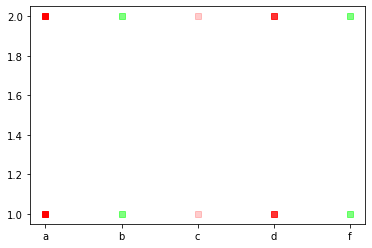

In [82]:
x_vals = ['a','b','c','d','f']
y_vals = [1,1,1,1,1]
y2_vals = [2,2,2,2,2]
colors = [(1,0,0,1),(0,1,0,.5),(1,0,0,.2),(1,0,0,.8),(0,1,0,.5)]
for i in range(5):
    plt.plot(x_vals[i],y_vals[i], 's',c = colors[i])
    plt.plot(x_vals[i], y2_vals[i], 's', c = colors[i])

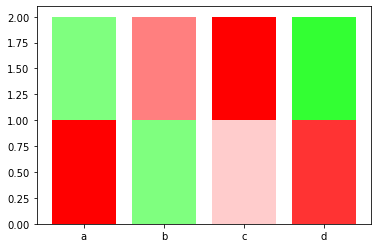

In [108]:
x_vals = ['a','b','c','d']
y_vals = 1
colors = [[(1,0,0,1),(0,1,0,.5),(1,0,0,.2),(1,0,0,.8),(0,1,0,.5)],[(0,1,0,.5),(1,0,0,.5),(1,0,0,1),(0,1,0,.8),(0,1,0,.75)]]
for j in range(len(colors)):
    for i in range(len(x_vals)):
        plt.bar(x_vals[i], y_vals,bottom=j, color=colors[j][i])

In [95]:
def get_length(df):
    df_ar = df.values
    return df_ar.shape

In [101]:
counts = get_length(new_dataframe)
counts

(58, 21)

In [106]:
short_dataframe = new_dataframe.head()
short_dataframe

d0               d1            d2               d3  \
MMM   (0, 1, 0, 0.38)  (0, 1, 0, 0.97)  (0, 1, 0, 1)  (0, 1, 0, 0.22)   
ABT   (0, 1, 0, 0.47)  (0, 1, 0, 0.67)  (1, 0, 0, 1)  (1, 0, 0, 0.63)   
ABBV  (0, 1, 0, 0.33)  (0, 1, 0, 0.76)  (1, 0, 0, 1)  (0, 1, 0, 0.24)   
ABMD  (0, 1, 0, 0.25)  (0, 1, 0, 0.87)  (1, 0, 0, 1)   (0, 1, 0, 0.6)   
ACN   (0, 1, 0, 0.34)  (0, 1, 0, 0.92)  (1, 0, 0, 1)     (0, 1, 0, 1)   

                   d4            d5               d6               d7  \
MMM   (0, 1, 0, 0.19)  (0, 1, 0, 1)  (0, 1, 0, 0.73)  (0, 1, 0, 0.01)   
ABT   (0, 1, 0, 0.98)  (1, 0, 0, 1)  (1, 0, 0, 0.37)     (0, 1, 0, 1)   
ABBV     (1, 0, 0, 1)  (0, 1, 0, 1)  (1, 0, 0, 0.13)     (0, 1, 0, 1)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 1)     (0, 1, 0, 1)     (0, 1, 0, 1)   
ACN    (0, 1, 0, 0.3)  (0, 1, 0, 1)  (0, 1, 0, 0.54)  (0, 1, 0, 0.59)   

                   d8               d9  ...           d11              d12  \
MMM   (1, 0, 0, 0.82)  (0, 1, 0, 0.24)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.83)   
ABT      (0, 1, 0, 1)  (1, 0, 0, 0.77)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.04)   
ABBV  (0, 1, 0, 0.43)  (0, 1, 0, 0.05)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.42)   
ABMD     (0, 1, 0, 1)  (1, 0, 0, 0.38)  ...  (0, 1, 0, 1)  (1, 0, 0, 0.32)   
ACN   (0, 1, 0, 0.66)  (0, 1, 0, 0.56)  ...  (0, 1, 0, 1)  (0, 1, 0, 0.44)   

                  d13              d14              d15              d16  \
MMM   (0, 1, 0, 0.04)  (1, 0, 0, 0.15)  (0, 1, 0, 0.53)     (0, 1, 0, 1)   
ABT      (1, 0, 0, 1)     (1, 0, 0, 1)  (0, 1, 0, 0.12)     (0, 1, 0, 1)   
ABBV  (1, 0, 0, 0.61)     (0, 1, 0, 1)     (1, 0, 0, 1)     (0, 1, 0, 1)   
ABMD  (0, 1, 0, 0.65)     (1, 0, 0, 1)  (0, 1, 0, 0.08)     (0, 1, 0, 1)   
ACN   (1, 0, 0, 0.94)     (1, 0, 0, 1)  (0, 1, 0, 0.34)  (1, 0, 0, 0.28)   

                  d17              d18              d19              d20  
MMM      (1, 0, 0, 1)  (0, 1, 0, 0.17)  (0, 1, 0, 0.71)     (1, 0, 0, 1)  
ABT   (1, 0, 0, 0.88)  (0, 1, 0, 0.42)     (0, 1, 0, 1)     (1, 0, 0, 1)  
ABBV  (1, 0, 0, 0.41)   (0, 1, 0, 0.3)     (0, 1, 0, 1)     (0, 1, 0, 1)  
ABMD     (0, 1, 0, 1)  (0, 1, 0, 0.41)     (0, 1, 0, 1)  (0, 1, 0, 0.06)  
ACN   (0, 1, 0, 0.14)   (0, 1, 0, 0.2)  (1, 0, 0, 0.48)     (0, 1, 0, 1)  

[5 rows x 21 columns]

Number of companies to compare: 10


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text major ticklabel objects>)

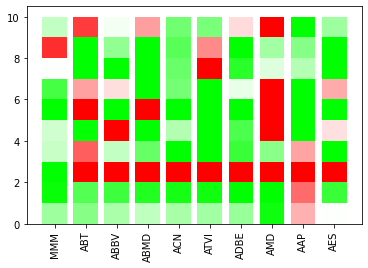

In [148]:
companies = list(new_dataframe.index)
#print(companies, len(companies))
#dates = new_dataframe.columns

selection = int(input("Number of companies to compare: "))

x_companies = companies[:selection]
y_date = 1

colors_data = new_dataframe.values[:selection]

#print(colors_data, len(colors_data))
for j in range(len(colors_data)):
    for i in range(selection):
        plt.bar(x_companies[i], y_date,bottom=j, color=colors_data[i][j])
        
plt.xticks(x_companies, rotation=90)
plt.yticks()

In [133]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Each of *y*, *width*, *height*, and *left* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    Parameters
    ----------
    y : scalar or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : scalar or array-like
        The width(s) of the bars.
    
    height : sequence of scalars, optional, default: 0.8
        The heights of the bars.
    
    left : sequence of scalars
        The x coordinates of the left sides of the bars (default: 0).
    
    align : {'center', 'edge'}, opt

In [134]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The vertical baseline
    is *bottom* (default 0).
    
    Each of *x*, *height*, *width*, and *bottom* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    Parameters
    ----------
    x : sequence of scalars
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : scalar or sequence of scalars
        The height(s) of the bars.
    
    width : scalar or array-like, optional
        The width(s) of the bars (default: 0.8).
    
    bottom : scalar or array-like, optional
        The y coordinate(s) of the bars bases (default: 0).
    
    align : {'cent

In [315]:
dates = list(new_dataframe.columns)[:20]

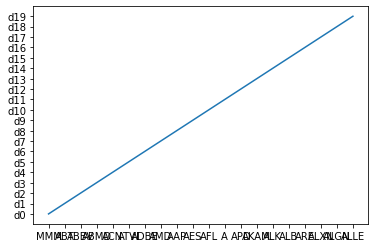

In [316]:
plt.plot(companies,dates)

In [334]:
help(plt)

Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    a MATLAB-like way of plotting.
    
    pyplot is mainly intended for interactive plots and simple cases of
    programmatic plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The object-oriented API is recommended for more complex plots.

FUNCTIONS
    acorr(x, *, data=None, **kwargs)
        Plot the autocorrelation of *x*.
        
        Parameters
        ----------
        x : array-like
        
        detrend : callable, optional, default: `mlab.detrend_none`
            *x* is detrended by the *detrend* callable. This must be a
            function ``x = detrend(x)`` accepting and returning an
            `numpy.array`. Default is no normalization.
        
        normed : bool

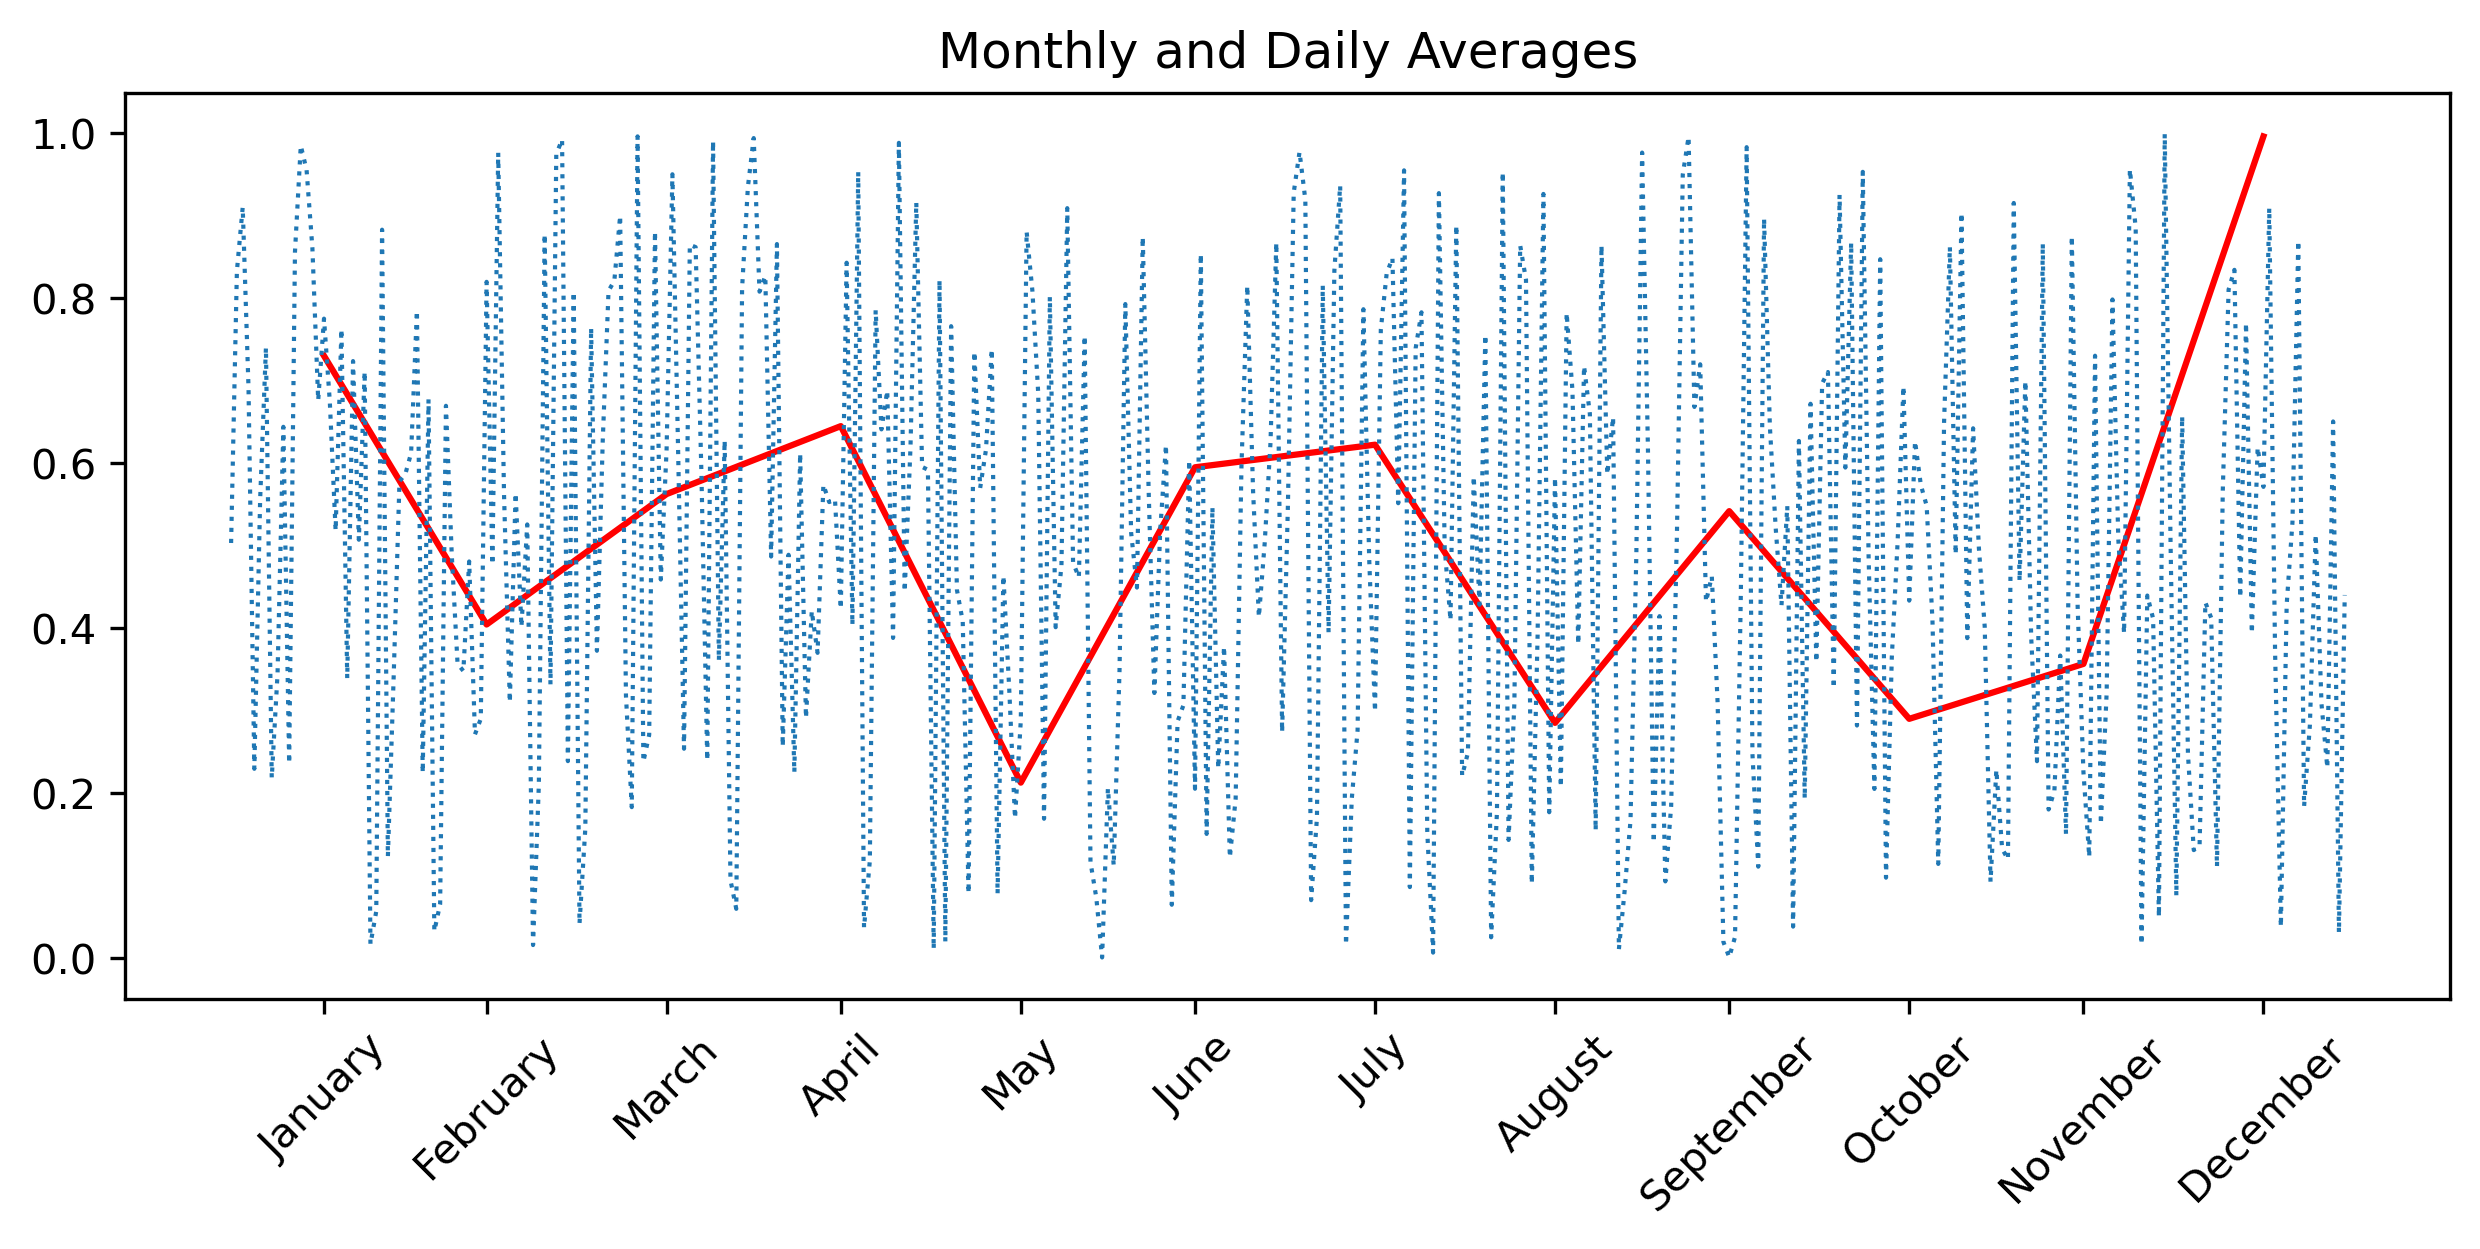

In [117]:
import matplotlib.pyplot as plt
import numpy as np

bcmonthly = np.random.rand(12)    # Creates some random example data,
dailyavg = np.random.rand(365)    # use your own data in place of this
days = np.linspace(0, 364, 365)
months = ['January', 'February', 'March', 'April', 'May',
          'June', 'July', 'August', 'September',
          'October', 'November', 'December']

lmonths = [0, 2, 4, 6, 7, 9, 11]
smonths = [3, 5, 8, 10]
month_idx = list()
idx = -15      # Puts the month avg and label in the center of the month
for jj in range(len(months)):
    if jj in lmonths:
        idx += 31
        month_idx.append(idx)
    elif jj in smonths:
        idx += 30
        month_idx.append(idx)
    elif jj == 1:
        idx += 28
        month_idx.append(idx)

fig = plt.figure(figsize=(10,4), dpi=300)  
plt.plot(month_idx,bcmonthly,'r')
plt.plot(days, dailyavg, ':', linewidth=1)
#plt.xlim([-1,366])
plt.title("Monthly and Daily Averages")
plt.xticks(month_idx, months, rotation=45)
plt.show()

In [337]:
len(month_idx)

12

In [340]:
bcmonthly

array([0.0103252 , 0.81652224, 0.37595467, 0.06118975, 0.46887242,
       0.2425946 , 0.11451575, 0.87302071, 0.46612986, 0.2798916 ,
       0.05502945, 0.88360041])

In [344]:
dailyavg.shape

(365,)

In [351]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The vertical baseline
    is *bottom* (default 0).
    
    Each of *x*, *height*, *width*, and *bottom* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    Parameters
    ----------
    x : sequence of scalars
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : scalar or sequence of scalars
        The height(s) of the bars.
    
    width : scalar or array-like, optional
        The width(s) of the bars (default: 0.8).
    
    bottom : scalar or array-like, optional
        The y coordinate(s) of the bars bases (default: 0).
    
    align : {'cent